In [46]:
from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, MessagesPlaceholder

from typing import TypedDict, List, Annotated, Literal, Union
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
import operator

from langgraph.types import Command, Send
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

from pydantic import BaseModel, Field

import uuid

from dotenv import load_dotenv

from prompts import *

load_dotenv()

True

In [47]:
def init_llm(
        provider: Literal["openai", "anthropic", "google", "ollama"],
        model: str,
        temperature: float = 0.5,
):
    if provider == "openai":
        return ChatOpenAI(model=model, temperature=temperature)
    elif provider == "anthropic":
        return ChatAnthropic(model=model, temperature=temperature)
    elif provider == "google":
        return ChatGoogleGenerativeAI(model=model, temperature=temperature)
    elif provider == "ollama":
        return ChatOllama(model=model, temperature=temperature)

In [48]:
llm = init_llm(
    provider="openai",
    model="gpt-4o-mini",
    temperature=0.5
)

In [ ]:
class Section(BaseModel):
    section_name: str = Field(..., description="The name of this section of the report without its number")
    sub_sections: List[str] = Field(..., description="Comprehensive descriptions of sub-sections, each combining the sub-section title and its bullet points into a fluid, natural-language description")

class Sections(BaseModel):
    sections: List[Section] = Field(..., description="A list of sections")

class Query(BaseModel):
    query: str = Field(..., description="A search query")

class Queries(BaseModel):
    queries: List[Query] = Field(..., description="A list of search queries")

class SearchResult(BaseModel):
    query: Query = Field(..., description="The search query that was used to retrieve the raw content")
    raw_content: list[str] = Field(..., description="The raw content retrieved from the search")

class Feedback(BaseModel):
    feedback: Union[str, bool] = Field(..., description="Feedback on the report structure. If the content is good for the section, return True (boolean), otherwise return a string of feedback on what is missing or incorrect.")

class SectionOutput(BaseModel):
    final_section_content: List[str] = Field(..., description="The final section content")


In [50]:
class AgentState(TypedDict):
    topic: str
    outline: str
    resource_path: str
    messages: Annotated[List[BaseMessage], operator.add]
    report_structure: str
    sections: List[Section]
    final_section_content: Annotated[List[str], operator.add] = []
    final_report_content: str

class ResearchState(TypedDict):
    section: Section
    knowledge: str
    reflection_feedback: Feedback = Feedback(feedback="")
    generated_queries: List[Query] = []
    searched_queries: Annotated[List[Query], operator.add] = []
    search_results: Annotated[List[SearchResult], operator.add] = []
    accumulated_content: str = ""
    reflection_count: int = 1
    final_section_content: Annotated[List[str], operator.add] = []

In [51]:
import os

from qdrant_setup import rag_pipeline_setup
from chunk_prep import create_chunks

def resource_setup_node(state: AgentState, config: RunnableConfig):
    thread_id = config.get("configurable").get("thread_id")
    directory_path = state.get("resource_path")
    chunks = create_chunks(directory_path)
    rag_pipeline_setup(thread_id, chunks)

In [53]:
report_structure_planner_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(REPORT_STRUCTURE_PLANNER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(
        template="""
        Topic: {topic}
        Outline: {outline}
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

report_structure_planner_llm = report_structure_planner_system_prompt | llm

def report_structure_planner_node(state: AgentState, config: RunnableConfig):
    result = report_structure_planner_llm.invoke(state)
    return {"messages": [result]}

In [54]:
def human_feedback_node(state: AgentState, config: RunnableConfig)->Command[Literal["section_formatter", "report_structure_planner"]]:
    human_message = input("Please provide feedback on the report structure (type 'continue' to continue): ")
    report_structure = state.get("messages")[-1].content
    if human_message == "continue":
        return Command(
            goto="section_formatter",
            update={"messages": [HumanMessage(content=human_message)], "report_structure": report_structure}
        )
    else:
        return Command(
            goto="report_structure_planner",
            update={"messages": [HumanMessage(content=human_message)]}
        )

In [56]:

section_formatter_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{report_structure}"),
])

section_formatter_llm = section_formatter_system_prompt | llm.with_structured_output(Sections)

def section_formatter_node(state: AgentState, config: RunnableConfig) -> Command[Literal["research_agent"]]:
    result = section_formatter_llm.invoke(state)
    # return {"sections": result.sections}
    return Command(
        update={"sections": result.sections},
        goto=[
            Send(
                "research_agent",
                {
                    "section": s,
                }
            ) for s in result.sections
        ]
    )

In [58]:
section_knowledge_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SECTION_KNOWLEDGE_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{section}"),
])

section_knowledge_llm = section_knowledge_system_prompt | llm

def section_knowledge_node(state: ResearchState, config: RunnableConfig):
    result = section_knowledge_llm.invoke(state)
    return {"knowledge": result.content}

In [60]:
def query_generator_node(state: ResearchState, config: RunnableConfig):
    query_generator_system_prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(QUERY_GENERATOR_SYSTEM_PROMPT_TEMPLATE),
        HumanMessagePromptTemplate.from_template(template="Section: {section}\nPrevious Queries: {searched_queries}\nReflection Feedback: {reflection_feedback}"),
    ])

    query_generator_llm = query_generator_system_prompt | llm.with_structured_output(Queries)
    state.setdefault("reflection_feedback", "")
    state.setdefault("searched_queries", [])
    configurable = config.get("configurable")

    input_data = {
        **state,
        **configurable  # includes max_queries, search_depth, etc.
    }

    result = query_generator_llm.invoke(input_data, configurable)
    return {"generated_queries": result.queries, "searched_queries": result.queries}


In [61]:
from qdrant_setup import retrieve_from_store

def rag_search_node(state: ResearchState, config: RunnableConfig):
    queries = state["generated_queries"]
    configurable = config.get("configurable")
    search_results = []
    for query in queries:
        raw_content = []
        response = retrieve_from_store(query.query, configurable.get("thread_id"), configurable.get("n_points"))
        for result in response:
            content = f"filename:{result.payload['document']['filename']}\nPage_number:{result.payload['document']['page_number']}\nPage_Content: {result.payload['document']["page_content"]}\n\n\n"
            raw_content.append(content)
        search_results.append(SearchResult(query=query, raw_content=raw_content))
    return {"search_results": search_results}

In [63]:
result_accumulator_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(RESULT_ACCUMULATOR_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{search_results}"),
])

result_accumulator_llm = result_accumulator_system_prompt | llm

def result_accumulator_node(state: ResearchState, config: RunnableConfig):
    result = result_accumulator_llm.invoke(state)
    return {"accumulated_content": result.content}

In [65]:
reflection_feedback_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(REFLECTION_FEEDBACK_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Section: {section}\nAccumulated Content: {accumulated_content}"),
])

reflection_feedback_llm = reflection_feedback_system_prompt | llm.with_structured_output(Feedback)

def reflection_feedback_node(state: ResearchState, config: RunnableConfig) -> Command[Literal["final_section_formatter", "query_generator"]]:
    reflection_count = state.get("reflection_count", 0)
    configurable = config.get("configurable")
    result = reflection_feedback_llm.invoke(state)
    feedback = result.feedback
    if (feedback == True) or (feedback.lower() == "true") or (reflection_count < configurable.get("num_reflections")):
        return Command(
            update={"reflection_feedback": feedback},
            goto="final_section_formatter"
        )
    else:
        return Command(
            update={"reflection_feedback": feedback, "reflection_count": reflection_count + 1},
            goto="query_generator"
        )

In [67]:
final_section_formatter_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(FINAL_SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Internal Knowledge: {knowledge}\nSearch Result content: {accumulated_content}"),
])

final_section_formatter_llm = final_section_formatter_system_prompt | llm

def final_section_formatter_node(state: ResearchState, config: RunnableConfig):
    result = final_section_formatter_llm.invoke(state)
    return {"final_section_content": [result.content]}


In [69]:
final_report_writer_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(FINAL_REPORT_WRITER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Report Structure: {report_structure}\nSection Contents: {final_section_content}"),
])

final_report_writer_llm = final_report_writer_system_prompt | llm

def final_report_writer_node(state: AgentState, config: RunnableConfig):
    result = final_report_writer_llm.invoke(state)
    return {"final_report_content": result.content}

In [70]:
research_builder = StateGraph(ResearchState, output=SectionOutput)

research_builder.add_node("section_knowledge", section_knowledge_node)
research_builder.add_node("query_generator", query_generator_node)
research_builder.add_node("rag_search", rag_search_node)
research_builder.add_node("result_accumulator", result_accumulator_node)
research_builder.add_node("reflection", reflection_feedback_node)
research_builder.add_node("final_section_formatter", final_section_formatter_node)

research_builder.add_edge(START, "section_knowledge")
research_builder.add_edge("section_knowledge", "query_generator")
research_builder.add_edge("query_generator", "rag_search")
research_builder.add_edge("rag_search", "result_accumulator")
research_builder.add_edge("result_accumulator", "reflection")
research_builder.add_edge("final_section_formatter", END)

memory_saver = MemorySaver()

builder = StateGraph(AgentState)

builder.add_node("resource_setup", resource_setup_node)
builder.add_node("report_structure_planner", report_structure_planner_node)
builder.add_node("human_feedback", human_feedback_node)
builder.add_node("section_formatter", section_formatter_node)
builder.add_node("research_agent", research_builder.compile())
builder.add_node("final_report_writer", final_report_writer_node)

builder.set_entry_point("resource_setup")
builder.add_edge("resource_setup", "report_structure_planner")
builder.add_edge("report_structure_planner", "human_feedback")
builder.add_edge("research_agent", "final_report_writer")
builder.add_edge("final_report_writer", END)

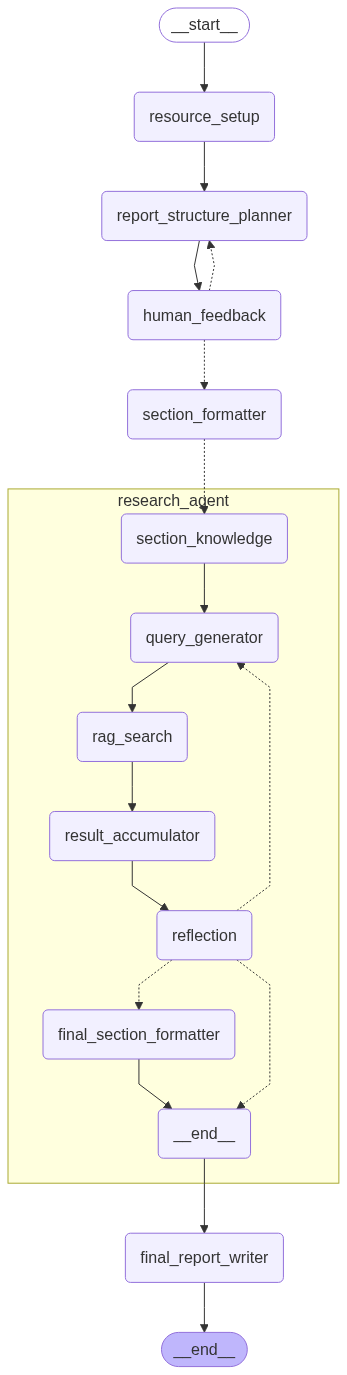

In [71]:
graph = builder.compile(checkpointer=memory_saver)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
TOPIC = "Research paper details"
OUTLINE = "I want some details on this research paper."

thread = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
        "max_queries": 3,
        "search_depth": 2,
        "num_reflections": 2,
        "n_points": 1
    }
}

for event in graph.stream(
    {"topic": TOPIC, "outline": OUTLINE, "resource_path": "./resource"},
    config=thread,
):
    if "resource_setup" in event:
        print("<<< RESOURCE SETUP >>>")
        print("Setting up the database for you...\n")
    elif "report_structure_planner" in event:
        print("<<< REPORT STRUCTURE PLANNER >>>")
        print(event["report_structure_planner"]["messages"][-1].content)
        print("\n", "="*100, "\n")
    elif "section_formatter" in event:
        print("<<< SECTION FORMATTING >>>")
        print(event["section_formatter"])
        print("\n", "="*100, "\n")
    elif "research_agent" in event:
        # check output of research_agent
        print("<<< RESEARCH AGENT >>>")
        print(event["research_agent"])
        print("\n", "="*100, "\n")
    elif "final_report_writer" in event:
        # check output of final_report_writer
        print("<<< FINAL REPORT WRITER >>>")
        print(event["final_report_writer"])
        print("\n", "="*100, "\n")
    else:
        print("<<< HUMAN FEEDBACK >>>")
        print(event["human_feedback"]["messages"][-1].content)
        print("\n", "="*100, "\n")
